In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# ENSEMBLE models

* to reduce bias and variance
* using different models as building block of the final mode => weak learners
* different models can have low bias and high variance or vice versa
* combining several weak learners into one model with better performance
* choice of the weak learners should be coherent with aggregation method

### BAGGING
* less variance than it's component
* parallel learning
* averaging process

### BOOSTING
* less bias than it's components 
* sequential learning, base model depends on the previous one

### STACKING
* less bias than it's components
* parallel learning 
* combination of output of weak learners is input into the metamodel

#### Reasons for using ensemble models
* small dataset
* non-linear complicated data

### Error(x) = Bias^2 + Variance + irreducible Error 
![variance vs bias](https://miro.medium.com/max/700/1*kISLC1Udq0m6g5kwHhMuJg@2x.png)

### DATA

In [2]:
# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=100, noise=0.45)
# split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.40)
print('Train', X.shape, y.shape, 'Test', X_test.shape, y_test.shape)

Train (600, 100) (600,) Test (400, 100) (400,)


In [3]:
# helper functions

def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, 
                         scoring='neg_mean_absolute_error', 
                         cv=10, 
                         n_jobs=-1)
    return scores

##  BOOSTING

#### types of algorithm
* AdaBoost (adaptive boosting)
* Gradient Boosting

### AdaBoost
https://link.springer.com/chapter/10.1007/978-3-642-41136-6_5
![AdaBoost](https://www.analyticsvidhya.com/wp-content/uploads/2015/11/boosting10-300x205.png)
* bigger weight for correctly predicted values


* not ideal for noisy data
* sensitive to outliers
* does not overfit 

#### scikit-learn example

In [4]:
from sklearn.ensemble import AdaBoostRegressor
# base_estimator = DecisionTreeRegressor(max_depth=3)

model = AdaBoostRegressor(random_state=0)
scores = evaluate_model(model, X, y)

print('MAE: %.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

MAE: 110.124 (8.741)


#### Hyperparameters: Learning rate
* Learning rate shrinks the contribution of each regressor by learning_rate. There is a trade-off between learning_rate and n_estimators

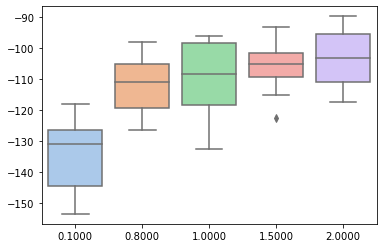

In [5]:
def get_models():
    models = dict()
    for i in [0.1, 0.8, 1.0, 1.5, 2.0]:
        models['%.4f' % i] = AdaBoostRegressor(learning_rate=i)
        
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_lr_ada = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_lr_ada, palette='pastel')

#### Hyperparameters: N estimators

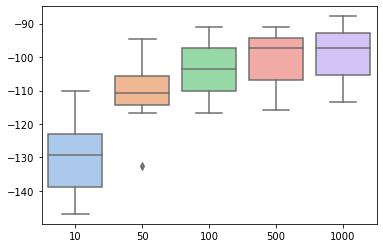

In [6]:
def get_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n)
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_est_ada = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_est_ada, palette='pastel')

#### Optimal hyperparameters combination

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

params = {'n_estimators': hp.choice('n_estimators', np.arange(10, 510, 50)),
          'loss': hp.choice('loss', ['linear', 'square', 'exponential']),
          'learning_rate':  hp.choice('learning_rate', [0.1, 0.8, 1.0, 1.5, 2.0])}


def objective(params):
    model = AdaBoostRegressor(n_estimators = params['n_estimators'], 
                              learning_rate = params['learning_rate'], 
                              loss = params['loss'], 
                              random_state=0)
    
    score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean()
    
    return {'loss': -score, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print('Best Score: %s' % best)

100%|█████████████████████████████████████████████████| 50/50 [30:07<00:00, 36.15s/trial, best loss: 82.87499685884366]
Best Score: {'learning_rate': 3, 'loss': 1, 'n_estimators': 9}


### Gradient Boosting
https://proceedings.neurips.cc/paper/1999/file/96a93ba89a5b5c6c226e49b88973f46e-Paper.pdf

* sequential
* decision trees models
* subsequent models trying to correct errors of the previous model

* generalization of AdaBoosting
* randomly sampling the samples and features when fitting ensemble members

* great performance, usualy part of the winning algorithms in ML competitions (LightBoost, XGBoost)

* any differentiable loss function and gradient descent optimization
* loss gradient is minimized while fitting the model, like in NN
* One way to produce a weighted combination of classifiers which optimizes [the cost] is by gradient descent in function space [Boosting Algorithms as Gradient Descent in Function Space, 1999.]


#### scikit-learn example

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
scores = cross_val_score(model, X, y, 
                         scoring='neg_mean_absolute_error', 
                         cv=10, 
                         n_jobs=-1)

print('MAE: %.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

MAE: 71.946 (6.882)


#### N estimators

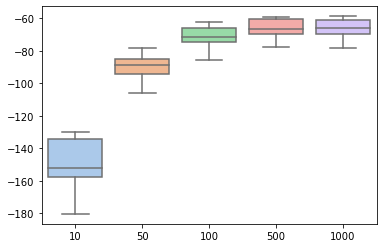

In [10]:
def get_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n)
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_est = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_est, palette='pastel')

#### N samples

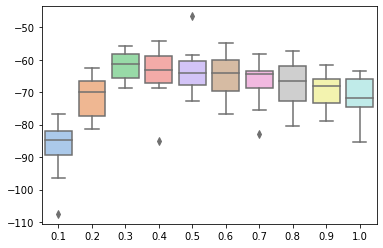

In [11]:
def get_models():
    models = dict()
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingRegressor(subsample=i)
        
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_samples = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_samples, palette='pastel')

#### N features

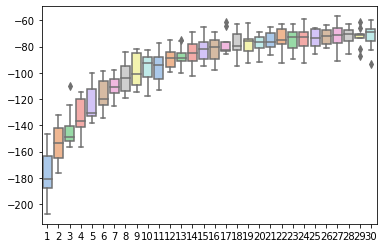

In [12]:
def get_models():
    models = dict()
    for i in np.arange(1, 31):
        models[str(i)] = GradientBoostingRegressor(max_features=i)
        
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_features = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_features, palette='pastel')

#### Learning rate

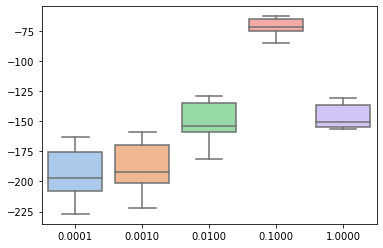

In [13]:
def get_models():
    models = dict()
    for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        models['%.4f' % i] = GradientBoostingRegressor(learning_rate=i)
        
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_lr = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_lr, palette='pastel')

#### Tree depth

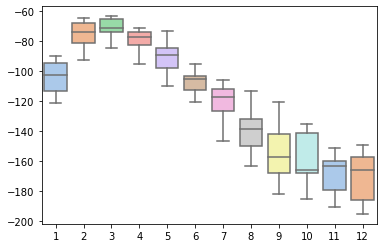

In [14]:
def get_models():
    models = dict()
    for i in range(1, 13):
        models[str(i)] = GradientBoostingRegressor(max_depth=i)
        
    return models

models = get_models()
results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    
df_depth = pd.DataFrame(np.array(results).T, columns=names)
g = sns.boxplot(data=df_depth, palette='pastel')

#### Optimal hyperparameters combination

In [20]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

params = {'subsample': hp.choice('subsample',np.arange(0.1, 1.1, 0.1)),
          'n_estimators': hp.choice('n_estimators',np.arange(10, 510, 50)),
          'max_features': hp.choice('max_features',range(1, 31)),
          'learning_rate':  hp.choice('learning_rate', [0.09, 0.1, 0.12, 0.15]),
          'max_depth':  hp.choice('max_depth',range(1, 13))}


def objective(params):
    model = GradientBoostingRegressor(subsample = params['subsample'],
                                      n_estimators = params['n_estimators'],
                                      max_features = params['max_features'],
                                      learning_rate = params['learning_rate'],
                                      max_depth = params['max_depth'],
                                      random_state=0)
    
    score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean()
    
    return {'loss': -score, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print('Best Score: %s' % best)

100%|█████████████████████████████████████████████████| 50/50 [05:32<00:00,  6.64s/trial, best loss: 49.22198683859722]
Best Score: {'learning_rate': 2, 'max_depth': 0, 'max_features': 29, 'n_estimators': 8, 'subsample': 1}


In [23]:
model = GradientBoostingRegressor(learning_rate=0.12,
                                  max_depth=1,
                                  max_features=range(1, 31)[29],
                                  n_estimators=np.arange(10,510,50)[8],
                                  subsample=np.arange(0.1, 1.1, 0.1)[1],
                                  random_state=0)

scores = evaluate_model(model, X, y)

print('MAE: %.3f (%.3f)' % (-np.mean(scores), np.std(scores)))

MAE: 49.222 (6.165)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

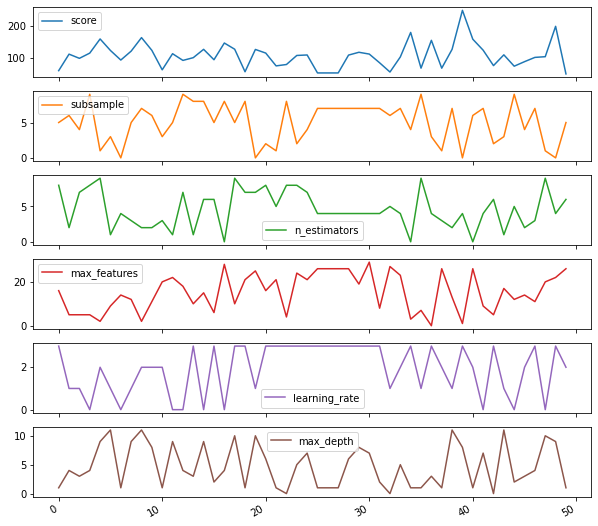

In [17]:
tpe_results = np.array([[x['result']['loss'],
                        x['misc']['vals']['subsample'][0],
                        x['misc']['vals']['n_estimators'][0],
                        x['misc']['vals']['max_features'][0],
                        x['misc']['vals']['learning_rate'][0],
                        x['misc']['vals']['max_depth'][0]] for x in trials.trials])

table = pd.DataFrame(tpe_results, columns=['score', 'subsample', 'n_estimators',
                                          'max_features', 'learning_rate', 'max_depth'])

table.plot(subplots=True,figsize=(10, 10))

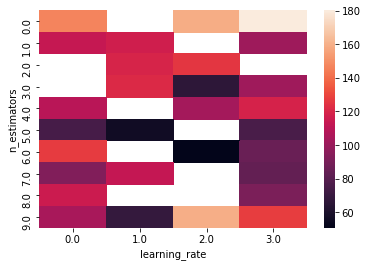

In [18]:
pivot_table = pd.pivot_table(table,
                       values='score', 
                       index='n_estimators', 
                       columns='learning_rate')
   
plot = sns.heatmap(pivot_table)

#### Random forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

params = {'max_depth':hp.quniform('max_depth',5, 20, 1),
          'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
          'n_estimators':hp.quniform('n_estimators', 100, 300, 20)}

def objective(params):
    model = RandomForestRegressor(max_depth = int(params['max_depth']),
                                 max_features = params['max_features'],
                                 n_estimators = int(params['n_estimators']) )
    
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error',).mean()
    
    return {'loss': -score, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)


print('Best Score: %s' % best)

100%|████████████████████████████████████████████████| 50/50 [16:20<00:00, 19.60s/trial, best loss: 120.01651915927076]
Best Score: {'max_depth': 12.0, 'max_features': 3, 'n_estimators': 240.0}
